# Initialization

In [1]:
# Name: Kaggle human or robot project codes
# Author: Bo QU
# Last modifying Date: 2018-7-25
# Python 3

#import the necessary libary
import numpy as np
import pandas as pd

from time import time
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pylab as pl
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import cross_validation,metrics
from sklearn.model_selection import GridSearchCV


from matplotlib.pylab import rcParams
rcParams['figure.figsize']=25,25

%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data querying

In [2]:
#Data querying
#Inputing the bidders account records
train_data=pd.read_csv('/floyd/input/humanorrobot/train.csv')
test_data=pd.read_csv('/floyd/input/humanorrobot/test.csv')
print('Train data:')
display(train_data.head(1))
print('')
print('Test data:')
display(test_data.head(1))

Train data:


,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0



Test data:


,bidder_id,payment_account,address
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,a3d2de7675556553a5f08e4c88d2c228htx90,5d9fa1b71f992e7c7a106ce4b07a0a754le7c


In [3]:
#The labeling information
print('Number of bidders in train data: ',len(train_data['outcome']))
print('Number of robot bidders: ',sum(train_data['outcome']))
print('Number of bidders in test data: ', len(test_data))
# A highly imbalanced data is observed, and the test set is larger, generalization from the training could have potential problems.

Number of bidders in train data:  2013
Number of robot bidders:  103.0
Number of bidders in test data:  4700


In [4]:
#Inputing the bidding records 
bid_data=pd.read_csv('//floyd/input/humanorrobot/bids.csv')
display(bid_data.head(3))

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3


In [5]:
print('Total number of bidders in bids data is:',bid_data['bidder_id'].nunique())
print('Total number of bidders in train data that are also in bids data:',bid_data.loc[bid_data['bidder_id'].isin(list(train_data['bidder_id']))]['bidder_id'].nunique())
print('Total number of bidders in test data that are also in bids data:',bid_data.loc[bid_data['bidder_id'].isin(list(test_data['bidder_id']))]['bidder_id'].nunique())

# In this project, there is no explicit features for us to use, we need to construct the features by our own.
# Noticing that not all test bidders records are included in the bid_data, this is noted by as a bug, and the solution is to label these missing bidders as -1 in the submission.csv.

test_no_record=test_data.loc[~test_data['bidder_id'].isin(list(bid_data['bidder_id']))]
test_no_record.set_index('bidder_id',inplace=True)
test_no_record.to_csv('test_no_record.csv')

Total number of bidders in bids data is: 6614
Total number of bidders in train data that are also in bids data: 1984
Total number of bidders in test data that are also in bids data: 4630


In [6]:
#How long does the bids record consist of?
#Approximately 9 days.
time_series=set(bid_data['time'])
time_series=list(time_series)
max_tim_stmp=max(time_series)
min_tim_stmp=min(time_series)
sec_9days=86400
tot_tim_sec=len(time_series)
print('The total number of different timepoints: ',tot_tim_sec)
print('The approximate duration of the bids data: ',len(time_series)/sec_9days,' days.')
print('The minimum time stamp: ',min_tim_stmp)
print('The maximum time stamp: ',max_tim_stmp)

The total number of different timepoints:  776529
The approximate duration of the bids data:  8.987604166666667  days.
The minimum time stamp:  9631916842105263
The maximum time stamp:  9772885210526315


# Features construction and labels

Function for features construction:
- raw_features()
    - Mean number of bids for each auction by every bidder.
    - Median number of bids for each auction by every bidder.
    - Variance of bids for each auction by every bidder.
    - Number of bids.
    - Variance of bid amounts in time intervals
    - Number of unique devices.
    - Mean number of unique devices used for auctions by every bidder.
    - Mean of same urls used per auction.
    - Variance of same urls used per auction.
    - Maximum number of diverse urls within all auctions by every bidder.
    - Mean of same ip used per auction.
    - Variance of same ip used per auction.
    - Bids number in 9 time intervals by each bidder.
    - Total bid time intervals for all auctions.
    - Mean bid time intervals between every bids for the auctions.
    - Total bid time periode (last bid time step- first bid time step) within all 9 days by every bidder.
    - Mean unique auction interested in time intervals
    - Unique auctions interested by each bidder
    - First bid rate.
    - Final bid rate.
    - Closed(First and Final) bid rate.
    
Function for labels:
- labels()

In [7]:
def labels(account_data,bid_data):
    print('')
    print('==========Generating labels...==========')
    labels=pd.DataFrame()
    labels['bidder_id']=account_data.loc[account_data['bidder_id'].isin(list(bid_data['bidder_id']))]['bidder_id']
    labels['outcome']=account_data.loc[account_data['bidder_id'].isin(list(bid_data['bidder_id']))]['outcome']
    
    labels.reset_index(inplace=True)
    labels=labels.drop(['index'],axis=1)
    labels.set_index('bidder_id',inplace=True)
    
    print('Number of the bidders labels:',len(labels))
    display(labels.head(1))
    
    #Output the labels
    labels.to_csv('labels.csv')
    print('labels outputed as: labels.csv')
    print('==========END==========')
    print('')

In [15]:
def raw_features(account_data,bid_data,name):
    
    print('')
    print('===========Generating raw features for {}...=========='.format(name))
    # Initializtion of the feature set and according labels.
    raw_features=pd.DataFrame()
    
    raw_features['bidder_id']=account_data.loc[account_data['bidder_id'].isin(list(bid_data['bidder_id']))]['bidder_id']
    
    raw_features.reset_index(inplace=True)
    raw_features=raw_features.drop(['index'],axis=1)
    
    print('Number of records: ',len(raw_features))
    
    
    #=========================================================Feature construction site========================================================= 
    time_series=set(bid_data['time'])
    time_series=list(time_series)
    max_tim_stmp=max(time_series)
    min_tim_stmp=min(time_series)
    sec_9days=86400
    tot_tim_sec=len(time_series)
    
    #Mean number of bids for each auction by every bidder.
    print('Mean number of bids for each auction by every bidder.')
    bidder_id_auction_df=pd.DataFrame(bid_data.groupby(['bidder_id','auction']).count().groupby(['bidder_id']).mean()).reset_index().rename(columns={'bid_id':'mean_num_auction_bids'})
    raw_features['mean_num_auction_bids']=bidder_id_auction_df.loc[bidder_id_auction_df['bidder_id'].isin(list(raw_features['bidder_id']))].set_index(['bidder_id']).reindex(index=raw_features['bidder_id']).reset_index()['mean_num_auction_bids']

    print('Median number of bids for each auction by every bidder.')
    #Median number of bids for each auction by every bidder.
    bidder_id_auction_df=pd.DataFrame(bid_data.groupby(['bidder_id','auction']).count().groupby(['bidder_id']).median()).reset_index().rename(columns={'bid_id':'median_num_auction_bids'})
    raw_features['median_num_auction_bids']=bidder_id_auction_df.loc[bidder_id_auction_df['bidder_id'].isin(list(raw_features['bidder_id']))].set_index(['bidder_id']).reindex(index=raw_features['bidder_id']).reset_index()['median_num_auction_bids']

    print('Variance number of bids for each auction by every bidder.')
    #Variance number of bids for each auction by every bidder.
    bidder_id_auction_df=pd.DataFrame(bid_data.groupby(['bidder_id','auction']).count().groupby(['bidder_id']).var().fillna(0)).reset_index().rename(columns={'bid_id':'var_num_auction_bids'})
    raw_features['var_num_auction_bids']=bidder_id_auction_df.loc[bidder_id_auction_df['bidder_id'].isin(list(raw_features['bidder_id']))].set_index(['bidder_id']).reindex(index=raw_features['bidder_id']).reset_index()['var_num_auction_bids']

    print('Number of bids by every bidder.')
    #Number of bids by every bidder.
    raw_features['number_of_bids']=pd.DataFrame(bid_data.loc[bid_data['bidder_id'].isin(list(raw_features['bidder_id']))].groupby(['bidder_id'])['bid_id'].count()).reindex(index=raw_features['bidder_id']).reset_index()['bid_id']

    print('Variance of bid amounts in time intervals.')
    #Variance of bid amounts in time intervals.
    raw_features['var_bids_num_per_time_interval']=pd.DataFrame(bid_data.loc[bid_data['bidder_id'].isin(list(raw_features['bidder_id']))].groupby(['bidder_id',pd.cut(bid_data.loc[bid_data['bidder_id'].isin(list(raw_features['bidder_id']))]['time'],500)])['bid_id'].count().groupby('bidder_id').var().fillna(0)).reindex(index=raw_features['bidder_id']).reset_index()['bid_id']
    
    print('Number of unique devices.')
    #Number of unique devices.
    raw_features['num_unique_devices']=pd.DataFrame(bid_data.loc[bid_data['bidder_id'].isin(list(raw_features['bidder_id']))].groupby('bidder_id')['device'].nunique()).reindex(index=raw_features['bidder_id']).reset_index()['device']
    
    print('Mean of unique devices used per auction.')
    #Mean of unique devices used per auction.
    raw_features['mean_unique_devices_per_auction']=pd.DataFrame(bid_data.loc[bid_data['bidder_id'].isin(list(raw_features['bidder_id']))].groupby(['bidder_id','auction'])['device'].nunique().groupby('bidder_id').mean()).reindex(index=raw_features['bidder_id']).reset_index()['device']
    
    print('Mean of same urls used per auction.')
    #Mean of same urls used per auction.
    raw_features['mean_same_url_per_auction']=pd.DataFrame(bid_data.loc[bid_data['bidder_id'].isin(list(raw_features['bidder_id']))].groupby(['bidder_id','auction','url'])['bid_id'].count().groupby('bidder_id').mean()).reindex(index=raw_features['bidder_id']).reset_index()['bid_id']
    
    print('Variance of same urls used per auction.')
    #Variance of same urls used per auction.
    raw_features['var_same_url_per_auction']=pd.DataFrame(bid_data.loc[bid_data['bidder_id'].isin(list(raw_features['bidder_id']))].groupby(['bidder_id','auction','url'])['bid_id'].count().groupby('bidder_id').var().fillna(0)).reindex(index=raw_features['bidder_id']).reset_index()['bid_id']
    
    print('Maximum number of diverse urls within all auctions by every bidder.')
    #Maximum number of diverse urls within all auctions by every bidder.
    raw_features['max_urls_per_auction']=pd.DataFrame(bid_data.loc[bid_data['bidder_id'].isin(list(raw_features['bidder_id']))].groupby(['bidder_id','auction'])['url'].nunique().groupby(['bidder_id']).max()).reindex(index=raw_features['bidder_id']).reset_index()['url']
    
    print('Mean of same ip used per auction.')
    #Mean of same ip used per auction.
    raw_features['mean_same_ip_per_auction']=pd.DataFrame(bid_data.loc[bid_data['bidder_id'].isin(list(raw_features['bidder_id']))].groupby(['bidder_id','auction','ip'])['bid_id'].count().groupby('bidder_id').mean()).reindex(index=raw_features['bidder_id']).reset_index()['bid_id']
    
    print('Var of same ip used per auction.')
    #Var of same ip used per auction.
    raw_features['var_same_ip_per_auction']=pd.DataFrame(bid_data.loc[bid_data['bidder_id'].isin(list(raw_features['bidder_id']))].groupby(['bidder_id','auction','ip'])['bid_id'].count().groupby('bidder_id').var().fillna(0)).reindex(index=raw_features['bidder_id']).reset_index()['bid_id']
    
    print('Bids number in 9 days by each bidder.')
    #Bids number in 9 days by each bidder.
    bid_data['time_range_9']=pd.cut(bid_data['time'],9,include_lowest=True)
    bid_in_ranges=pd.DataFrame(bid_data.groupby(['bidder_id','time_range_9']).count().fillna(0)['bid_id'])
    bid_in_ranges=pd.DataFrame(pd.pivot_table(bid_in_ranges,values=['bid_id'],columns=['time_range_9'],index=['bidder_id']).to_records())
    bid_in_ranges.columns=['bidder_id','bids_day1','bids_day2','bids_day3','bids_day4','bids_day5','bids_day6','bids_day7','bids_day8','bids_day9']

    bid_in_ranges=bid_in_ranges.loc[bid_in_ranges['bidder_id'].isin(list(raw_features['bidder_id']))].set_index(['bidder_id']).reindex(raw_features['bidder_id']).reset_index()
    bid_in_ranges=bid_in_ranges.drop(['bidder_id'],axis=1)
    raw_features=pd.concat([raw_features,bid_in_ranges],axis=1)
    
    print('Total bid time intervals for all auctions')
    #Total bid time intervals for all auctions
    raw_features['tot_bid_time_all_auctions']=pd.DataFrame(bid_data.loc[bid_data['bidder_id'].isin(list(raw_features['bidder_id']))].sort_values(by=['bidder_id','auction']).groupby(['bidder_id','auction'])['time'].apply(lambda x:(max(x)-min(x))/(max_tim_stmp-min_tim_stmp)*tot_tim_sec).groupby('bidder_id').sum()).reindex(index=raw_features['bidder_id']).reset_index()['time']
    
    print('Mean number of time interval between each bid by every bidder.')
    #Mean number of time interval between each bid by every bidder.
    bid_data['bid_time_interval']=bid_data.sort_values(by=['bidder_id','time']).groupby(['bidder_id'])['time'].diff().fillna(0).apply(lambda x:x/(max_tim_stmp-min_tim_stmp)*tot_tim_sec)
    raw_features['mean_bid_time_interval']=pd.DataFrame(bid_data.loc[bid_data['bidder_id'].isin(list(raw_features['bidder_id']))].groupby(['bidder_id'])['bid_time_interval'].mean()).reindex(index=raw_features['bidder_id']).reset_index()['bid_time_interval']

    print('Mean unique auction interested in time intervals.')
    #Mean unique auction interested in time intervals.
    raw_features['mean_unique_auction_interested_in_time_intervals']=pd.DataFrame(bid_data.loc[bid_data['bidder_id'].isin(list(raw_features['bidder_id']))].sort_values(by=['time']).groupby(['bidder_id',pd.cut(bid_data.loc[bid_data['bidder_id'].isin(list(raw_features['bidder_id']))]['time'],500)])['auction'].nunique().groupby('bidder_id').mean()).reindex(index=raw_features['bidder_id']).reset_index()['auction']
    
    print('Number of unique auctions by every bidder.')
    #Number of unique auctions by every bidder.
    raw_features['num_of_unique_auctions']=pd.DataFrame(bid_data.loc[bid_data['bidder_id'].isin(list(raw_features['bidder_id']))].groupby(['bidder_id'])['auction'].nunique()).reindex(index=raw_features['bidder_id']).reset_index()['auction']

    print('Total bid time periode (last bid time step- first bid time step) within all 9 days by every bidder.')
    #Total bid time periode (last bid time step- first bid time step) within all 9 days by every bidder.
    raw_features['tot_bid_periode']=pd.DataFrame(bid_data.loc[bid_data['bidder_id'].isin(list(raw_features['bidder_id']))].groupby(['bidder_id'])['time'].apply(lambda x:(max(x)-min(x)))).reindex(index=raw_features['bidder_id']).reset_index()['time']
 
    print('Bid rates.')
    # First bid rate.
    # Final bid rate.
    # Closed(First and Final) bid rate.
    auction_bid_time=pd.DataFrame(bid_data.groupby(['auction'])['time'].min()).rename(columns={'time':'min_tim'})
    auction_bid_time['max_tim']=bid_data.groupby(['auction'])['time'].max()
    bidder_bt=pd.DataFrame(bid_data.groupby(['bidder_id','auction'])['time'].min()).rename(columns={'time':'min_tim'})
    bidder_bt['max_tim']=pd.DataFrame(bid_data.groupby(['bidder_id','auction'])['time'].max()).rename(columns={'time':'min_tim'})

    raw_features['first_bid']=0.
    raw_features['final_bid']=0.
    raw_features['f_f_bid']=0.
    
    for bidder in raw_features['bidder_id']:
        for auction in bid_data.loc[bid_data['bidder_id']==bidder]['auction'].unique():
            #print(bots_bt.loc[(bidder,auction),'min_tim']==auction_bid_time.loc[auction,'min_tim'])
            if bidder_bt.loc[(bidder,auction),'min_tim']==auction_bid_time.loc[auction,'min_tim'] and bidder_bt.loc[(bidder,auction),'max_tim']!=auction_bid_time.loc[auction,'max_tim'] :
                raw_features.loc[raw_features.index[raw_features['bidder_id']==bidder],'first_bid']+=1
            elif bidder_bt.loc[(bidder,auction),'min_tim']!=auction_bid_time.loc[auction,'min_tim'] and bidder_bt.loc[(bidder,auction),'max_tim']==auction_bid_time.loc[auction,'max_tim'] :
                raw_features.loc[raw_features.index[raw_features['bidder_id']==bidder],'final_bid']+=1
            elif bidder_bt.loc[(bidder,auction),'min_tim']==auction_bid_time.loc[auction,'min_tim'] and bidder_bt.loc[(bidder,auction),'max_tim']==auction_bid_time.loc[auction,'max_tim'] :
                raw_features.loc[raw_features.index[raw_features['bidder_id']==bidder],'f_f_bid']+=1
    
    raw_features['first_bid']=raw_features['first_bid']/raw_features['number_of_bids']
    raw_features['final_bid']=raw_features['final_bid']/raw_features['number_of_bids']
    raw_features['f_f_bid']=raw_features['f_f_bid']/raw_features['number_of_bids']
    #=========================================================END========================================================= 
    
    
    #Setting the bidder_id as index
    raw_features.set_index('bidder_id',inplace=True)
    
    print('Number of features: ',len(raw_features.columns))
    display(raw_features.head(1))

    
    # output the raw feature construction
    raw_features.to_csv('raw_features_{}.csv'.format(name))

    print('raw features for {} outputed as: raw_features_{}.csv'.format(name,name))
    print('===========END=========='.format(name))
    print('')

# Feature processes and selections

Functions for feature processes and selections:
- prep():
    - Log transformation
    - MinMaxScaler
    
    
- psi_f():
    - **Population stability index** for comparing the feature distributions between train data and test data, in order to do the feature selection so that the distribution of features in training set are close to the testing set.
    
- f_imp():
    - Select the important features according to the algrithm.

In [3]:
# Data preprocesses
def prep(raw_features,exclude=[]):
    
    prep_features=pd.DataFrame()
    #Listing the columns
    numerical=list(raw_features.columns)
    
    for e in exclude:
        try:
            numerical.remove(e)
        except:
            print('Removing name %s not in the feature set.'%e)
    
    #Data preprocessed by log transformation
    prep_features[numerical]=raw_features[numerical].apply(lambda x:np.log(x+1e-5))
    
    #Data preprocessed by MinMaxScaler
    scalar=MinMaxScaler()
    prep_features[numerical]=scalar.fit_transform(raw_features[numerical])
    
    return prep_features
    

In [4]:
#psi calculation detail for each feature
def psi_cal(bench,compare,group):
    ben_len=len(bench)
    comp_len=len(compare)
    psi_cut=[]
    ben_pct_l=[]
    comp_pct_l=[]
    
    _,bins=pd.qcut(bench,group,labels=False,retbins=True,duplicates='drop')
    ben_bin=pd.DataFrame(np.array(range(len(bins))),index=bins[0:len(bins)])
    
    if len(ben_bin)<=2:
        #<
        ben_pct=len([b for b in bench if b<ben_bin.index[len(ben_bin)-1]+0.0])/ben_len
        comp_pct=len([c for c in compare if c<ben_bin.index[len(ben_bin)-1]+0.0])/comp_len
        try:
            psi_cut.append((comp_pct-ben_pct)*math.log(comp_pct/ben_pct))
        except (ValueError,ZeroDivisionError):
            psi_cut.append(float('nan'))
        
        ben_pct_l.append(ben_pct)
        comp_pct_l.append(comp_pct)
        
        #>=
        ben_pct=len([b for b in bench if b>=ben_bin.index[len(ben_bin)-1]+0.0])/ben_len
        comp_pct=len([c for c in compare if c>=ben_bin.index[len(ben_bin)-1]+0.0])/comp_len
        try:
            psi_cut.append((comp_pct-ben_pct)*math.log(comp_pct/ben_pct))
        except (ValueError,ZeroDivisionError):
            psi_cut.append(float('nan'))
        ben_pct_l.append(ben_pct)
        comp_pct_l.append(comp_pct)
        
        df_report = pd.DataFrame(pd.np.zeros([2, 4]), index=range(2),
                                 columns=["bands", "ben_pct", "comp_pct", "index"])
        bands =[-99999999,ben_bin.index[len(ben_bin)-1]]
        (df_report["bands"], df_report["ben_pct"], df_report["comp_pct"], df_report["index"]) = \
        (bands, ben_pct_l, comp_pct_l, psi_cut)
        
    else:
        for i in range(1,len(ben_bin)):
            if i==1:
                ben_pct=len([b for b in bench if b<ben_bin.index[i]+0.0])/ben_len
                comp_pct=len([c for c in compare if c<ben_bin.index[i]+0.0])/comp_len
              
            
            elif i==len(ben_bin)-1:
                ben_pct=len([b for b in bench if b>=ben_bin.index[i-1]+0.0])/ben_len
                comp_pct=len([c for c in compare if c>=ben_bin.index[i-1]+0.0])/comp_len

            else:
                ben_pct=len([b for b in bench if b>=ben_bin.index[i-1]+0.0 and b<ben_bin.index[i]+0.0])/ben_len
                comp_pct=len([c for c in compare if c>=ben_bin.index[i-1]+0.0 and c<ben_bin.index[i]+0.0])/comp_len
            
            try:
                psi_cut.append((comp_pct-ben_pct)*math.log(comp_pct/ben_pct))
            except (ValueError,ZeroDivisionError):
                psi_cut.append(float('nan')) 
                
            ben_pct_l.append(ben_pct)
            comp_pct_l.append(comp_pct)
            
        df_report=pd.DataFrame(np.zeros([len(ben_bin)-1,4]),index=range(1,len(ben_bin)),columns=['bands','ben_pct','comp_pct','psi_cut'])
    
        bands=list(ben_bin.index)
        bands[0]=-99999999
        df_report['bands'],df_report['ben_pct'],df_report['comp_pct'],df_report['psi_cut']= \
        bands[0:len(bands)-1],ben_pct_l,comp_pct_l,psi_cut
    
    psi=round(sum(psi_cut),6)
    
    return df_report, psi
                
#psi calcuation for all the features                
def psi_f(features_list,benches,compares,group):
    psi_f={'feature':[],'psi_report':[],'psi':[]}
    for i in range(len(features_list)):
        psi_f['feature'].append(features_list[i])
        df,psi=psi_cal(benches[features_list[i]],compares[features_list[i]],group)
        psi_f['psi_report'].append(df)
        psi_f['psi'].append(psi)
    
    return psi_f



In [5]:
#feature importance for algrithm
def f_imp(alg,features,labels,threshold=0.001):
    clf=alg
    clf.fit(features,labels.values.ravel())
    slm=SelectFromModel(clf,prefit=True,threshold=threshold)
    
    f_ind=slm.get_support(indices=True)
    f_imp=[list(features.columns)[i] for i in f_ind]
    
    feat_imp=pd.DataFrame(clf.feature_importances_,index=features.columns,columns=['feature_imp']).sort_values(by=['feature_imp'],ascending=False)
    fig=feat_imp.plot(kind='bar',title='Feature Importances')
    plt.axhline(y=threshold, color='r', linestyle='--',label='Threshold')
    plt.ylabel('Feature Importance Score',fontsize=20)
    plt.legend()
    
    print('{}/{} features selected under threshold {}.'.format(len(f_imp),len(features.columns),threshold))
    print('============= Important features ===============')
    print(f_imp)
    print('====================END ========================')
    return f_imp 
    
    

In [6]:
#Eliminating the one bid robots
#By data exploration we could find there are 5 robot bidders who only has one bidding records
#These records could be a potential miss leading message for the training
#This function is for eliminating these bidders from the train data.
def drop_one_bid_bots(df,do=True):
    outliers=['bd0071b98d9479130e5c053a244fe6f1muj8h','91c749114e26abdb9a4536169f9b4580huern','74a35c4376559c911fdb5e9cfb78c5e4btqew','f35082c6d72f1f1be3dd23f949db1f577t6wd','7fab82fa5eaea6a44eb743bc4bf356b3tarle']
    if sum([o in df.index for o in outliers])==len(outliers) and do:
        print('eliminated')
        return df.drop(index=outliers)
    else:
        print('No elimination')
        return df
    

In [7]:
#Select features by their variance 
def variance_sel(features):
    from sklearn.feature_selection import VarianceThreshold

    sel=VarianceThreshold(threshold=0.001)
    sel.fit(features)
    print('features after filtering low variance：',list(features.columns[sel.get_support()]))
    
    #return a list of the features name selected
    return list(features.columns[sel.get_support()])

# Raw features for train/test and labels outputs

In [16]:
labels(train_data,bid_data)
raw_features(train_data,bid_data,'train')
raw_features(test_data,bid_data,'test')


==========Generating labels...==========
Number of the bidders labels: 1984


,outcome
bidder_id,
91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0


labels outputed as: labels.csv
==========END==========


===========Generating raw features for train...==========
Number of records:  1984
Mean number of bids for each auction by every bidder.
Median number of bids for each auction by every bidder.
Variance number of bids for each auction by every bidder.
Number of bids by every bidder.
Variance of bid amounts in time intervals.
Number of unique devices.
Mean of unique devices used per auction.
Mean of same urls used per auction.
Variance of same urls used per auction.
Maximum number of diverse urls within all auctions by every bidder.
Mean of same ip used per auction.
Var of same ip used per auction.
Bids number in 9 days by each bidder.
Total bid time intervals for all auctions
Mean number of time interval between each bid by every bidder.
Mean unique auction interested in time intervals.
Number of unique auctions by every bidder.
Total bid time periode (last bid time step- first bid time step) within all 9 days by every bidder.
Bid

,mean_num_auction_bids,median_num_auction_bids,var_num_auction_bids,number_of_bids,var_bids_num_per_time_interval,num_unique_devices,mean_unique_devices_per_auction,mean_same_url_per_auction,var_same_url_per_auction,max_urls_per_auction,...,bids_day8,bids_day9,tot_bid_time_all_auctions,mean_bid_time_interval,mean_unique_auction_interested_in_time_intervals,num_of_unique_auctions,tot_bid_periode,first_bid,final_bid,f_f_bid
bidder_id,,,,,,,,,,,,,,,,,,,,,
91a3c57b13234af24875c56fb7e2b2f4rb56a,1.333333,1.0,0.352941,24,0.507353,14,1.333333,1.333333,0.352941,1,...,0.0,24.0,29599.090799,3014.907439,1.294118,18,13135578947369,0.0,0.0,0.0


raw features for train outputed as: raw_features_train.csv
===========END==========


===========Generating raw features for test...==========
Number of records:  4630
Mean number of bids for each auction by every bidder.
Median number of bids for each auction by every bidder.
Variance number of bids for each auction by every bidder.
Number of bids by every bidder.
Variance of bid amounts in time intervals.
Number of unique devices.
Mean of unique devices used per auction.
Mean of same urls used per auction.
Variance of same urls used per auction.
Maximum number of diverse urls within all auctions by every bidder.
Mean of same ip used per auction.
Var of same ip used per auction.
Bids number in 9 days by each bidder.
Total bid time intervals for all auctions
Mean number of time interval between each bid by every bidder.
Mean unique auction interested in time intervals.
Number of unique auctions by every bidder.
Total bid time periode (last bid time step- first bid time step) within all

,mean_num_auction_bids,median_num_auction_bids,var_num_auction_bids,number_of_bids,var_bids_num_per_time_interval,num_unique_devices,mean_unique_devices_per_auction,mean_same_url_per_auction,var_same_url_per_auction,max_urls_per_auction,...,bids_day8,bids_day9,tot_bid_time_all_auctions,mean_bid_time_interval,mean_unique_auction_interested_in_time_intervals,num_of_unique_auctions,tot_bid_periode,first_bid,final_bid,f_f_bid
bidder_id,,,,,,,,,,,,,,,,,,,,,
49bb5a3c944b8fc337981cc7a9ccae41u31d7,1.333333,1.0,0.333333,4,0.0,2,1.0,1.0,0.0,2,...,0.0,0.0,25038.604789,96707.381747,1.0,3,70223684210526,0.0,0.0,0.0


raw features for test outputed as: raw_features_test.csv
===========END==========



# Models first comparison

First model selection with raw features
- Random Forest
- GBDT
- Xgboost

In [24]:
#Read the latest raw features and labels file.
raw_features_train=pd.read_csv('raw_features_train.csv',index_col='bidder_id')
labels=pd.read_csv('labels.csv',index_col='bidder_id')



In [25]:
#At this point, only simple feature preprocesses are used.
prep_features_train=prep(raw_features_train)

In [4]:
def model_compare(models,feature_set,label_set,model_names,colors,kfold=10):
    from matplotlib.pylab import rcParams
    rcParams['figure.figsize']=15,15
    for model in models:
        model_name=model_names[models.index(model)]
        color=colors[models.index(model)]
        cv=StratifiedKFold(n_splits=kfold)
        tprs=[]
        aucs=[]
        mean_fpr=np.linspace(0,1,100)

        i=0
        for train, val in cv.split(feature_set,label_set):
            probas_=model.fit(feature_set.iloc[train],label_set.iloc[train].values.ravel()).predict_proba(feature_set.iloc[val])
            #compute ROC curve and AUC
            fpr,tpr,threshold=roc_curve(label_set.iloc[val].values.ravel(),probas_[:,1])
            tprs.append(interp(mean_fpr,fpr,tpr))
            tprs[-1][0]=0.0
            roc_auc=auc(fpr,tpr)
            aucs.append(roc_auc)
        #    plt.plot(fpr1,tpr1,lw=1,alpha=0.3,label='ROC fold %d (AUC=%0.2f)' % (i,roc_auc1))
    
            i+=1
    
    

        mean_tpr=np.mean(tprs,axis=0)
        mean_tpr[-1]=1.0
        mean_auc=auc(mean_fpr,mean_tpr)
        std_auc=np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color=color,
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f) %s' % (mean_auc, std_auc,model_name),
             lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.2,
                     label=r'$\pm$ 1 std. dev. %s'%(model_name))
    
    plt.plot([0,1],[0,1],linestyle='--',lw=2,color='r',label='Luck',alpha=0.8)
    plt.legend(loc='lower right',fontsize=20)

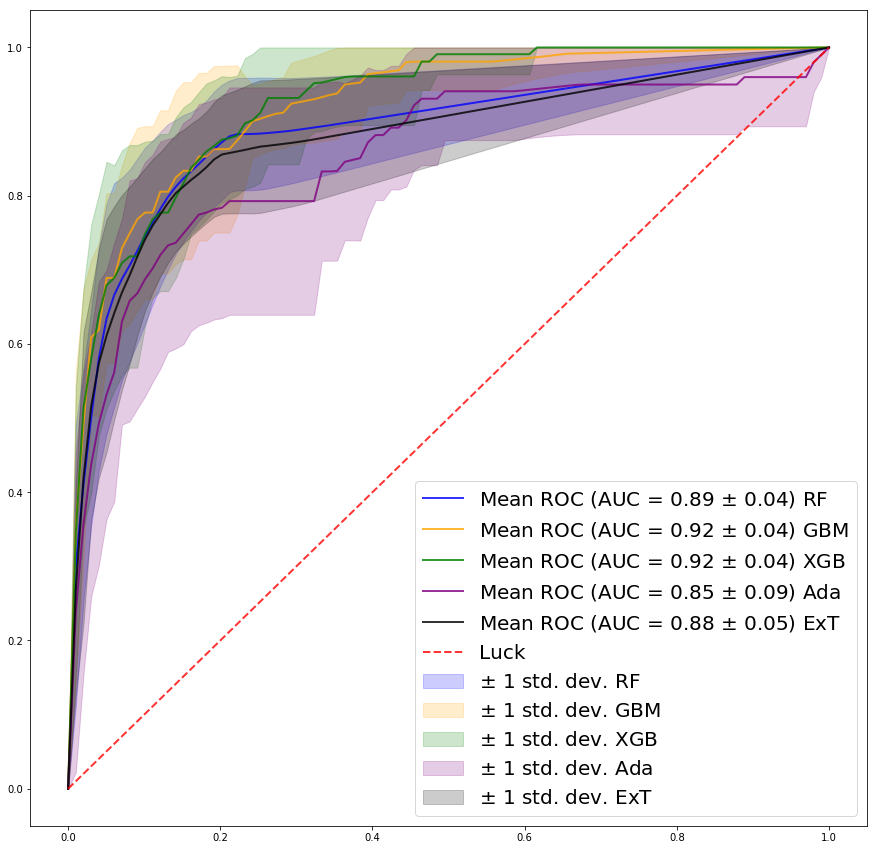

In [27]:
classifier1=RandomForestClassifier(random_state=10)
classifier2=GradientBoostingClassifier(random_state=10)
classifier3=XGBClassifier(random_state=10)
classifier4=AdaBoostClassifier(random_state=10)
classifier5=ExtraTreesClassifier(random_state=10)

classifiers=[classifier1,classifier2,classifier3,classifier4,classifier5]
model_names=['RF','GBM','XGB','Ada','ExT']
colors=['blue','orange','green','purple','black']

model_compare(classifiers,prep_features_train,labels,model_names,colors)

# XGBoost

XGBoost shows a relatively more promising performance at this point, In the following this estimator will be exploited.

## Raw features extraction and feature selections

In [8]:
#Read the latest raw features and labels file.
prep_features_train=pd.read_csv('raw_features_train.csv',index_col='bidder_id')
prep_features_test=pd.read_csv('raw_features_test.csv',index_col='bidder_id')
labels=pd.read_csv('labels.csv',index_col='bidder_id')


In [9]:
#Eliminating the one bid robots from the training data?
prep_features_train=drop_one_bid_bots(prep_features_train,do=True)
prep_features_test=prep_features_test
prep_labels=drop_one_bid_bots(labels,do=True)

eliminated
eliminated


In [10]:
#Eliminate the feature with PSI>0.1
features_list=list(prep_features_train.columns)

psi_df=psi_f(features_list,prep_features_test,prep_features_train,group=50)

show_df=pd.DataFrame(psi_df['psi'],index=psi_df['feature'],columns=['PSI score'])
display(show_df)

f_rm=[]
for i in psi_df['psi']:
    if i>0.1 or math.isnan(i):
        f_rm.append(psi_df['feature'][psi_df['psi'].index(i)])

print('{} features eliminated, includes: '.format(len(f_rm)))
print(f_rm)

prep_features_train.drop(columns=f_rm,inplace=True)
prep_features_test.drop(columns=f_rm,inplace=True)


,PSI score
mean_num_auction_bids,0.030848
median_num_auction_bids,0.009824
var_num_auction_bids,0.022333
number_of_bids,0.023714
var_bids_num_per_time_interval,0.015419
num_unique_devices,0.021357
mean_unique_devices_per_auction,0.017881
mean_same_url_per_auction,0.018286
var_same_url_per_auction,0.021267
max_urls_per_auction,0.017570


6 features eliminated, includes: 
['bids_day2', 'bids_day3', 'bids_day4', 'bids_day6', 'bids_day7', 'bids_day8']


In [11]:
prep_features_train=prep(prep_features_train)
prep_features_test=prep(prep_features_test)

23/23 features selected under threshold 0.001.
============= Important features ===============
['mean_num_auction_bids', 'median_num_auction_bids', 'var_num_auction_bids', 'number_of_bids', 'var_bids_num_per_time_interval', 'num_unique_devices', 'mean_unique_devices_per_auction', 'mean_same_url_per_auction', 'var_same_url_per_auction', 'max_urls_per_auction', 'mean_same_ip_per_auction', 'var_same_ip_per_auction', 'bids_day1', 'bids_day5', 'bids_day9', 'tot_bid_time_all_auctions', 'mean_bid_time_interval', 'mean_unique_auction_interested_in_time_intervals', 'num_of_unique_auctions', 'tot_bid_periode', 'first_bid', 'final_bid', 'f_f_bid']
====================END ========================


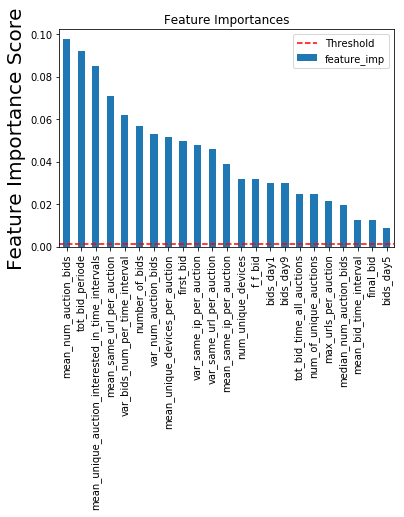

In [12]:
alg=XGBClassifier(random_state=10)
f_imp_l=f_imp(alg,prep_features_train,prep_labels,threshold=0.001)

prep_features_train=prep_features_train[f_imp_l]
prep_features_test=prep_features_test[f_imp_l]

In [13]:
#variance selection >0.001
#f_sel_l=variance_sel(prep_features_train)
#prep_features_train=prep_features_train[f_sel_l]
#prep_features_test=prep_features_test[f_sel_l]

In [14]:
#Output processed features
prep_features_train.to_csv('prep_feature_train.csv')
prep_features_test.to_csv('prep_feature_test.csv')
prep_labels.to_csv('prep_labels.csv')

## Preprocessed data loading

In [2]:
prep_features_train=pd.read_csv('prep_feature_train.csv',index_col=0)
prep_features_test=pd.read_csv('prep_feature_test.csv',index_col=0)
prep_labels=pd.read_csv('prep_labels.csv',index_col=0)

## Model fitting

In [3]:
#modelfit fucntion for XGBoost
def modelfit(alg,train_set,label_set,useTrainCV=True,cv_folds=10,early_stopping_rounds=50,n_repeats=10):
    import xgboost as xgb
    if useTrainCV:
        xgb_param=alg.get_xgb_params()
        xgtrain=xgb.DMatrix(train_set,label_set.values.ravel())
        cvresult=xgb.cv(xgb_param,xgtrain,num_boost_round=alg.get_params()['n_estimators'],nfold=cv_folds,metrics='auc',early_stopping_rounds=early_stopping_rounds,verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
        print('Optimum number of estimators is %d'% cvresult.shape[0])
    
    cv_=RepeatedStratifiedKFold(n_splits=cv_folds,n_repeats=n_repeats,random_state=10)
    aucs=[]
    for train, val in cv_.split(train_set,label_set):
        alg.fit(train_set.iloc[train],label_set.iloc[train].values.ravel(),eval_metric='auc')
    
        dtrain_predprob=alg.predict_proba(train_set.iloc[val])[:,1]
    
        aucs.append(metrics.roc_auc_score(label_set.iloc[val].values.ravel(),dtrain_predprob))
    
    print('Mean AUC score with {} repeats is {}'.format(n_repeats,np.mean(aucs)))
    

In [4]:
#sum(negative results)/sum(positive results)
scale_pos_weight=(len(prep_labels['outcome'])-sum(prep_labels['outcome']))/(sum(prep_labels['outcome']))

xgb1=XGBClassifier(learning_rate=0.001,n_estimators=500,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

modelfit(xgb1,prep_features_train,prep_labels,useTrainCV=True,cv_folds=5,n_repeats=50)


Optimum number of estimators is 16
Mean AUC score with 50 repeats is 0.9254692411654453


# Test prediction

In [5]:
def pred(alg,test_set,test_no_record_set,train_set,label_set,output):
    alg.fit(train_set,label_set.values.ravel(),eval_metric='auc')
    
    test_predprob_df=pd.DataFrame(index=test_set.index)
    bug_test_df=pd.DataFrame(index=test_no_record_set.index)

    bug_test_df['prediction']=-1

    dtest_predprob=alg.predict_proba(test_set)[:,1]

    test_predprob_df['prediction']=dtest_predprob


    test_predprob_df=test_predprob_df.append(bug_test_df,ignore_index=False)
    
    # Output the submission file
    test_predprob_df.to_csv(output,index=True,index_label='bidder_id')

In [6]:
test_no_record=pd.read_csv('test_no_record.csv',index_col=0)

xgb1=XGBClassifier(learning_rate=0.001,n_estimators=500,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

pred(xgb1,prep_features_test,test_no_record,prep_features_train,prep_labels,'submission_2018-7-24.csv')

## Parameters tuning

In [18]:
def parameter_tuning(estimator,features,labels,p_t_dict,t_names,scoring='roc_auc',cv=5):
    from matplotlib.pylab import rcParams
    rcParams['figure.figsize']=5,5
    params=p_t_dict
    gsearch=GridSearchCV(estimator=estimator,param_grid=params,scoring=scoring,iid=False,cv=cv)
    gsearch.fit(features,labels.values.ravel())

    
    if len(t_names)==1:
        x=np.zeros(len(p_t_dict[t_names[0]]))
        for index, item in enumerate(gsearch.cv_results_['mean_test_score']):
            x[index] =  item
        plt.plot(p_t_dict[t_names[0]], x,label=t_names[0])
        plt.title('Best %s : %f with auc_score : %f'% (t_names[0], gsearch.best_params_[t_names[0]], gsearch.best_score_))
        plt.show()
    else:
        for n in t_names:
            print('best %s: '%m,gsearch.best_params_[n])
        print('best mean score：',gsearch.best_score_)

In [19]:
scale_pos_weight=(len(prep_labels['outcome'])-sum(prep_labels['outcome']))/(sum(prep_labels['outcome']))


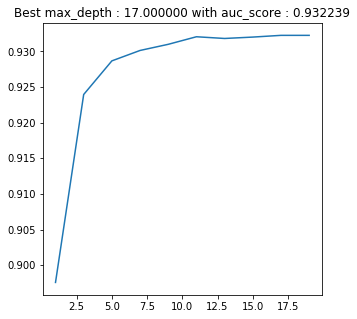

In [20]:
#max_depth
p_t_dict={'max_depth':[i for i in range(1,20,2)]}
t_names=['max_depth']
xgb1=XGBClassifier(learning_rate=0.001,n_estimators=16,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

parameter_tuning(xgb1,prep_features_train,prep_labels,p_t_dict,t_names)

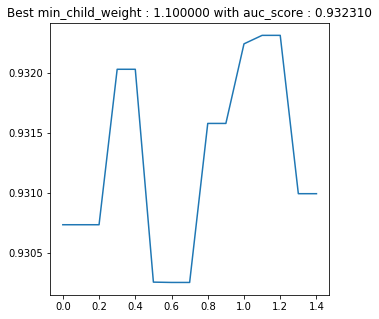

In [21]:
#min_child_weight
p_t_dict={'min_child_weight':[i/10 for i in range(0,15)]}
t_names=['min_child_weight']
xgb2=XGBClassifier(learning_rate=0.001,n_estimators=16,max_depth=17,gamma=0,subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

parameter_tuning(xgb2,prep_features_train,prep_labels,p_t_dict,t_names)

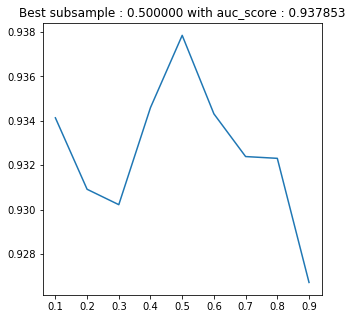

In [22]:
#subsample
p_t_dict={'subsample':[i/10. for i in range(1,10)]}
t_names=['subsample']
xgb4=XGBClassifier(learning_rate=0.001,n_estimators=16,max_depth=17,min_child_weight=1.1,gamma=0,colsample_bytree=0.8,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

parameter_tuning(xgb4,prep_features_train,prep_labels,p_t_dict,t_names)

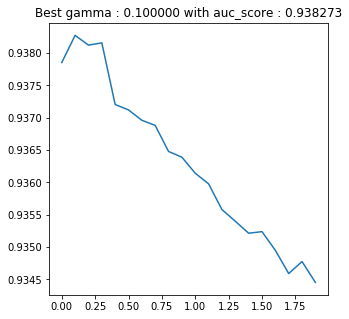

In [23]:
#gamma
p_t_dict={'gamma':[i/10. for i in range(20)]}
t_names=['gamma']
xgb3=XGBClassifier(learning_rate=0.001,n_estimators=16,max_depth=17,min_child_weight=1.1,subsample=0.5,colsample_bytree=0.8,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

parameter_tuning(xgb3,prep_features_train,prep_labels,p_t_dict,t_names)

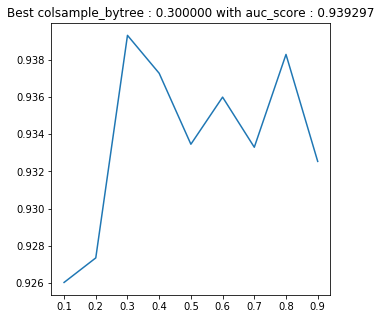

In [24]:
#colsample_bytree
p_t_dict={'colsample_bytree':[i/10. for i in range(1,10)]}
t_names=['colsample_bytree']
xgb5=XGBClassifier(learning_rate=0.001,n_estimators=16,max_depth=17,min_child_weight=1.1,gamma=0.1,subsample=0.5,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

parameter_tuning(xgb5,prep_features_train,prep_labels,p_t_dict,t_names)

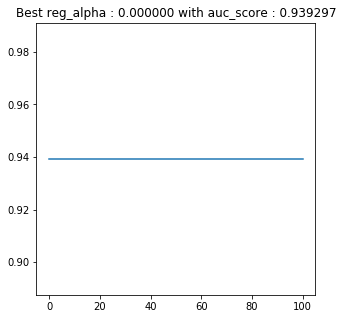

In [25]:
#reg_alpha

p_t_dict={'reg_alpha':[0,1e-5, 1e-2, 0.1, 1,10,100]}
t_names=['reg_alpha']
xgb6=XGBClassifier(learning_rate=0.001,n_estimators=16,max_depth=17,min_child_weight=1.1,gamma=0.1,subsample=0.5,colsample_bytree=0.3,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

parameter_tuning(xgb6,prep_features_train,prep_labels,p_t_dict,t_names)

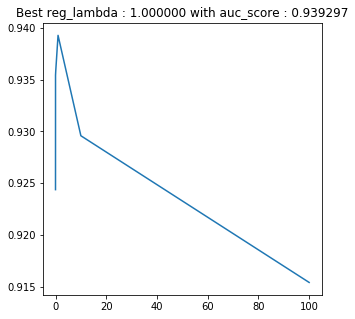

In [26]:
#reg_lambda
p_t_dict={'reg_lambda':[0,1e-5, 1e-2, 0.1, 1,10,100]}
t_names=['reg_lambda']
xgb7=XGBClassifier(learning_rate=0.001,n_estimators=16,max_depth=17,min_child_weight=1.1,gamma=0.1,subsample=0.5,colsample_bytree=0.3,reg_alpha=0.0,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

parameter_tuning(xgb7,prep_features_train,prep_labels,p_t_dict,t_names)

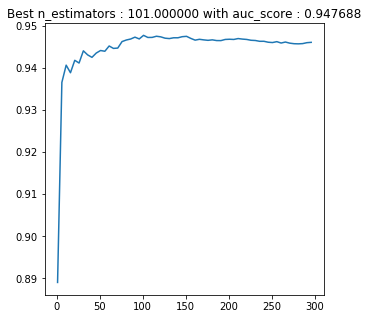

In [27]:
#n_estimator with smaller lr
p_t_dict={'n_estimators':[i for i in range(1,300,5)]}
t_names=['n_estimators']
xgb8=XGBClassifier(learning_rate=0.0005,max_depth=17,min_child_weight=1.1,gamma=0.1,subsample=0.5,colsample_bytree=0.3,reg_alpha=0.0,reg_lambda=1.0,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

parameter_tuning(xgb8,prep_features_train,prep_labels,p_t_dict,t_names)

In [28]:
xgb8=XGBClassifier(learning_rate=0.0005,n_estimators=101,max_depth=17,min_child_weight=1.1,gamma=0.1,subsample=0.5,colsample_bytree=0.3,reg_alpha=0.0,reg_lambda=1.0,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

modelfit(xgb8,prep_features_train,prep_labels,useTrainCV=False,cv_folds=5,n_repeats=50)

Mean AUC score with 50 repeats is 0.9420625415105996


## Test prediction

In [29]:
def pred(alg,test_set,test_no_record_set,train_set,label_set,output):
    alg.fit(train_set,label_set.values.ravel(),eval_metric='auc')
    
    test_predprob_df=pd.DataFrame(index=test_set.index)
    bug_test_df=pd.DataFrame(index=test_no_record_set.index)

    bug_test_df['prediction']=-1

    dtest_predprob=alg.predict_proba(test_set)[:,1]

    test_predprob_df['prediction']=dtest_predprob


    test_predprob_df=test_predprob_df.append(bug_test_df,ignore_index=False)
    
    # Output the submission file
    test_predprob_df.to_csv(output,index=True,index_label='bidder_id')

In [30]:
test_no_record=pd.read_csv('test_no_record.csv',index_col=0)

xgb=XGBClassifier(learning_rate=0.0005,n_estimators=101,max_depth=17,min_child_weight=1.1,gamma=0.1,subsample=0.5,colsample_bytree=0.3,reg_alpha=0.0,reg_lambda=1.0,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

pred(xgb,prep_features_test,test_no_record,prep_features_train,prep_labels,'submission_2018-7-25_4.csv')



## Ensemble test prediction

In [7]:
def ensemble_avg_pred(algs,test_set,test_no_record_set,train_set,label_set,output,ranking):
    predictors=[]
    for alg in algs:
        try:
            predictors.append(alg.fit(train_set,label_set.values.ravel(),eval_metric='auc'))
        except:
            predictors.append(alg.fit(train_set,label_set.values.ravel()))
    
    test_predprob_df=pd.DataFrame(index=test_set.index)
    bug_test_df=pd.DataFrame(index=test_no_record_set.index)
    bug_test_df['prediction']=-1
    dtest_predprob=pd.DataFrame()
    
    for i in range(len(predictors)):
        dtest_predprob[str(i)]=(predictors[i].predict_proba(test_set)[:,1])
    
    for i in ranking:
        dtest_predprob[str(i)]=dtest_predprob[str(i)].rank(pct=True)
    

    test_predprob_df['prediction']=list(dtest_predprob.mean(axis=1))


    test_predprob_df=test_predprob_df.append(bug_test_df,ignore_index=False)
    
    # Output the submission file
    test_predprob_df.to_csv(output,index=True,index_label='bidder_id')

In [10]:
xgb8=XGBClassifier(learning_rate=0.0005,n_estimators=101,max_depth=17,min_child_weight=1.1,gamma=0.1,subsample=0.5,colsample_bytree=0.3,reg_alpha=0.0,reg_lambda=1.0,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)


xgb9=XGBClassifier(learning_rate=0.001,n_estimators=16,max_depth=17,min_child_weight=1.1,gamma=0.1,subsample=0.5,colsample_bytree=0.3,reg_alpha=0.0,reg_lambda=1.0,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

modelfit(xgb9,prep_features_train,prep_labels,useTrainCV=False,cv_folds=5,n_repeats=20)

xgb10=XGBClassifier(learning_rate=0.01,n_estimators=100,max_depth=5,min_child_weight=1.1,gamma=0.0,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.0,reg_lambda=1.0,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

modelfit(xgb10,prep_features_train,prep_labels,useTrainCV=False,cv_folds=5,n_repeats=20)

xgb11=XGBClassifier(learning_rate=0.05,n_estimators=50,max_depth=5,min_child_weight=0.8,gamma=0.0,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.0,reg_lambda=0.0,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

modelfit(xgb11,prep_features_train,prep_labels,useTrainCV=False,cv_folds=5,n_repeats=20)

Mean AUC score with 20 repeats is 0.9353259403561742
Mean AUC score with 20 repeats is 0.9310904585770254
Mean AUC score with 20 repeats is 0.9287947328692663


In [11]:
test_no_record=pd.read_csv('test_no_record.csv',index_col=0)

scale_pos_weight=(len(prep_labels['outcome'])-sum(prep_labels['outcome']))/(sum(prep_labels['outcome']))

algs=[xgb8,xgb9,xgb10,xgb11]

ensemble_avg_pred(algs,prep_features_test,test_no_record,prep_features_train,prep_labels,'submission_2018-7-25_5_ens.csv',ranking=[0,1,2,3])

# Model validation

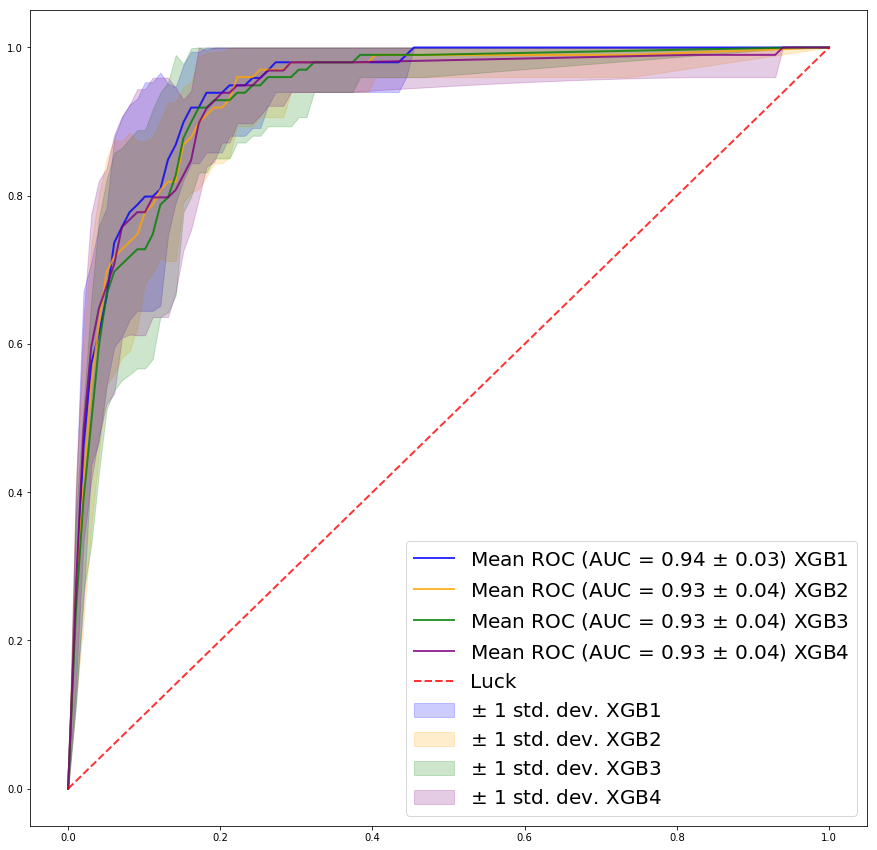

In [6]:

scale_pos_weight=(len(prep_labels['outcome'])-sum(prep_labels['outcome']))/(sum(prep_labels['outcome']))
model_names=['XGB1','XGB2','XGB3','XGB4']
colors=['blue','orange','green','purple']

xgb_1=XGBClassifier(learning_rate=0.0005,n_estimators=101,max_depth=17,min_child_weight=1.1,gamma=0.1,subsample=0.5,colsample_bytree=0.3,reg_alpha=0.0,reg_lambda=1.0,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

xgb_2=XGBClassifier(learning_rate=0.001,n_estimators=16,max_depth=17,min_child_weight=1.1,gamma=0.1,subsample=0.5,colsample_bytree=0.3,reg_alpha=0.0,reg_lambda=1.0,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

xgb_3=XGBClassifier(learning_rate=0.01,n_estimators=100,max_depth=5,min_child_weight=1.1,gamma=0.0,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.0,reg_lambda=1.0,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

xgb_4=XGBClassifier(learning_rate=0.05,n_estimators=50,max_depth=5,min_child_weight=0.8,gamma=0.0,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.0,reg_lambda=0.0,objective='binary:logistic',scale_pos_weight=scale_pos_weight,seed=10)

algs=[xgb_1,xgb_2,xgb_3,xgb_4]

model_compare(algs,prep_features_train,prep_labels,model_names,colors)